In [3]:
import pandas as pd
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
import pathlib

In [4]:
image_dir = '../input/animefacedataset/images'
len(os.listdir(image_dir))

63565

In [5]:
image_dir = pathlib.Path(image_dir)
images = list(image_dir.glob('*.jpg'))
len(images)

63565

In [6]:
image_data = images[:30000]

In [7]:
from keras import Input, layers
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout,Conv2DTranspose,Conv2D,Activation,BatchNormalization,LeakyReLU
from keras.optimizers import Adam
from keras.initializers import RandomNormal
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [8]:
#Generator

def create_generator(input_shape):
    kernel_init = 'glorot_uniform'

    generator_model = Sequential([
#         Input(shape = input_shape),
        Conv2DTranspose(filters = 512,kernel_size = (4,4),strides = (1,1),padding = 'valid',input_shape= input_shape, data_format = 'channels_last',kernel_initializer = kernel_init),
        BatchNormalization(momentum=0.5),
        LeakyReLU(0.2),
        
        Conv2DTranspose(filters = 256,kernel_size = (4,4),strides = (2,2),padding = 'same', data_format = 'channels_last',kernel_initializer = kernel_init),
        BatchNormalization(momentum=0.5),
        LeakyReLU(0.2),
        
        Conv2DTranspose(filters = 128,kernel_size = (4,4),strides = (2,2),padding = 'same', data_format = 'channels_last',kernel_initializer = kernel_init),
        BatchNormalization(momentum=0.5),
        LeakyReLU(0.2),
        
        Conv2DTranspose(filters = 64,kernel_size = (4,4),strides = (2,2),padding = 'same', data_format = 'channels_last',kernel_initializer = kernel_init),
        BatchNormalization(momentum=0.5),
        LeakyReLU(0.2),
        
        Conv2D(filters = 64,kernel_size = (3,3),strides = (1,1),padding = 'same', data_format = 'channels_last',kernel_initializer = kernel_init),
        BatchNormalization(momentum=0.5),
        LeakyReLU(0.2),
        
        Conv2DTranspose(filters = 3,kernel_size = (4,4),strides = (2,2),padding = 'same', data_format = 'channels_last',kernel_initializer = kernel_init),
        Activation('tanh')
    ])
    
    generator_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00015, beta_1=0.5), metrics=['accuracy'])
    generator_model.summary()
    
    return generator_model


In [9]:
generator = create_generator((1,1,100))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         819712    
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 512)         2048      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         2097408   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       5

In [10]:
def create_discriminator(input_shape = (64,64,3)):
    kernel_init = 'glorot_uniform'

    discriminator_model = Sequential([
#         Input(shape = input_shape),
        Conv2D(filters = 64,kernel_size = (4,4),strides = (2,2),padding = "same",input_shape = input_shape, data_format = "channels_last", kernel_initializer = kernel_init),
        LeakyReLU(0.2),
        Conv2D(filters = 128,kernel_size = (4,4),strides = (2,2),padding = "same", data_format = "channels_last", kernel_initializer = kernel_init),
        BatchNormalization(momentum = 0.5),
        LeakyReLU(0.2),
        
        Conv2D(filters = 256,kernel_size = (4,4),strides = (2,2),padding = "same", data_format = "channels_last", kernel_initializer = kernel_init),
        BatchNormalization(momentum = 0.5),
        LeakyReLU(0.2),
        
        Conv2D(filters = 512,kernel_size = (4,4),strides = (2,2),padding = "same", data_format = "channels_last", kernel_initializer = kernel_init),
        BatchNormalization(momentum = 0.5),
        LeakyReLU(0.2),
        
        Flatten(),
        Dense(1),
        Activation('sigmoid')
    ])
    
    discriminator_model.compile(loss='binary_crossentropy', optimizer= Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
    discriminator_model.summary()
    
    return discriminator_model

In [11]:
discriminator = create_discriminator()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         524544    
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 256)        

In [12]:
from keras.models import Model

def create_gan(g_model,d_model,noise_shape):
    d_model.trainable = False
    
    gen_input = Input(shape=noise_shape)
    GAN_input = g_model(gen_input)
    GAN_output = d_model(GAN_input)
    gan_model = Model(inputs = gen_input, outputs = GAN_output)
    gan_model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
    gan_model.summary()
    
    return gan_model

In [13]:
def random_noise(batch_size,noise_shape):
    return np.random.normal(0,1,size = (batch_size,)+noise_shape )

In [14]:
def generate_fake_samples(g_model,batch_size,noise_shape):
    x = random_noise(batch_size,noise_shape)
    X = g_model.predict(x)
    y = np.zeros((batch_size, 1))
    return X, y

def generate_real_samples(dataset,batch_size):
    idx = np.random.randint(0,dataset.shape[0],batch_size)
    X = dataset[idx]
    y = np.ones((batch_size, 1))
    return X,y

In [15]:
batch_size = 64
noise_shape = (1,1,100)
num_steps = 10000
image_shape = (64,64,3)

In [27]:
from PIL import Image
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

def save_img_batch(img_batch,step_no):
    plt.figure(figsize=(4,4))
    gs1 = gridspec.GridSpec(4, 4)
    gs1.update(wspace=0, hspace=0)
    rand_indices = np.random.choice(img_batch.shape[0],16,replace=False)
    for i in range(16):
        #plt.subplot(4, 4, i+1)
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        rand_index = rand_indices[i]
        image = img_batch[rand_index, :,:,:]
        img = (image+1)*127.5
        img = img.astype(np.uint8)
        plt.axis('off')
        ax1.axes.get_xaxis().set_visible(False)
        ax1.axes.get_yaxis().set_visible(False)
        plt.imshow(img)
    plt.tight_layout()
    plt.savefig('./image_'+str(step_no)+'.png',bbox_inches='tight',pad_inches=0)


In [22]:
def train_gan(g_model,d_model,gan_model,dataset,batch_size,noise_shape,num_steps):
    dLoss,gLoss = list(), list()
    data = np.array(dataset)
    for i in range(num_steps):
        X_real, Y_real =  generate_real_samples(data,batch_size)
        X_fake, Y_fake =  generate_fake_samples(g_model,batch_size,noise_shape)
        
        data_X = np.concatenate([X_real,X_fake])
        data_Y = np.concatenate([Y_real,Y_fake])
        
        d_loss, _ = d_model.train_on_batch(data_X, data_Y)
        dLoss.append(d_loss)
        
        x_gan = random_noise(batch_size,noise_shape)
        y_gan = np.ones((batch_size,1))
        
        g_loss = gan_model.train_on_batch(x_gan, y_gan)
        gLoss.append(g_loss)
        
        if i%100 == 0 :
            print('Epoch : {}, d_loss = {}, g_loss = {} '.format(i,d_loss,g_loss))
            
        if i%500 == 0:
            rand_indices = np.random.choice(data.shape[0],16,replace=False)
            save_img_batch(X_fake,i)
        

In [18]:
image_list = list()

for image in image_data:
    img = cv2.imread(str(image))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(64,64))
    img = np.array(img)
    img = (img/127.5)-1
    image_list.append(img)

In [21]:
gan_model = create_gan(generator,discriminator,noise_shape)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1, 100)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 3)         3616771   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 2768321   
Total params: 6,385,092
Trainable params: 3,614,723
Non-trainable params: 2,770,369
_________________________________________________________________


Epoch : 0, d_loss = 0.917855978012085, g_loss = [0.6272982358932495, 1.0] 
Epoch : 100, d_loss = 0.21069279313087463, g_loss = [14.423601150512695, 0.0] 
Epoch : 200, d_loss = 0.049478545784950256, g_loss = [5.90515661239624, 0.171875] 
Epoch : 300, d_loss = 0.05971270427107811, g_loss = [6.559900283813477, 0.0] 
Epoch : 400, d_loss = 0.059272896498441696, g_loss = [7.357370376586914, 0.0] 
Epoch : 500, d_loss = 0.5756474733352661, g_loss = [15.34817886352539, 0.0] 
Epoch : 600, d_loss = 0.1288476288318634, g_loss = [10.57120418548584, 0.0] 
Epoch : 700, d_loss = 0.07226285338401794, g_loss = [6.089127063751221, 0.0] 
Epoch : 800, d_loss = 0.3988375663757324, g_loss = [10.663337707519531, 0.0] 
Epoch : 900, d_loss = 0.10666632652282715, g_loss = [2.8443856239318848, 0.046875] 
Epoch : 1000, d_loss = 0.12287427484989166, g_loss = [6.51384162902832, 0.0] 
Epoch : 1100, d_loss = 0.1643364131450653, g_loss = [8.692108154296875, 0.0] 
Epoch : 1200, d_loss = 0.0750068724155426, g_loss = [0.9

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch : 10100, d_loss = 0.10873342305421829, g_loss = [3.846733570098877, 0.046875] 
Epoch : 10200, d_loss = 0.06187445670366287, g_loss = [7.2979207038879395, 0.0] 
Epoch : 10300, d_loss = 0.2548145055770874, g_loss = [17.56927490234375, 0.0] 
Epoch : 10400, d_loss = 0.12536302208900452, g_loss = [2.9293761253356934, 0.15625] 
Epoch : 10500, d_loss = 0.15192903578281403, g_loss = [2.116983413696289, 0.328125] 
Epoch : 10600, d_loss = 0.035331353545188904, g_loss = [4.022732734680176, 0.03125] 
Epoch : 10700, d_loss = 0.03883882239460945, g_loss = [1.0944817066192627, 0.640625] 
Epoch : 10800, d_loss = 0.10884234309196472, g_loss = [9.344931602478027, 0.0] 
Epoch : 10900, d_loss = 0.1428714543581009, g_loss = [15.145895004272461, 0.0] 
Epoch : 11000, d_loss = 0.10099224001169205, g_loss = [4.105433464050293, 0.09375] 
Epoch : 11100, d_loss = 0.05913689732551575, g_loss = [2.920844554901123, 0.3125] 
Epoch : 11200, d_loss = 0.07870795577764511, g_loss = [1.3655366897583008, 0.640625] 
E

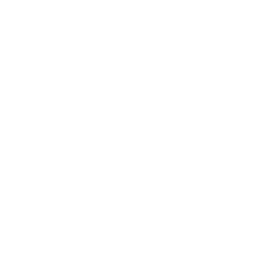

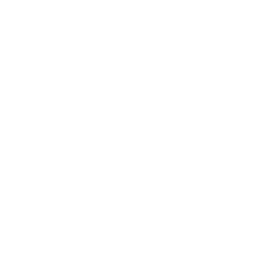

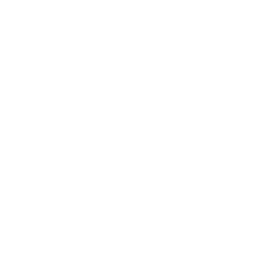

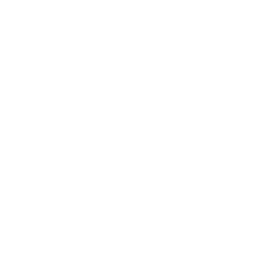

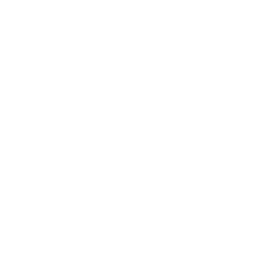

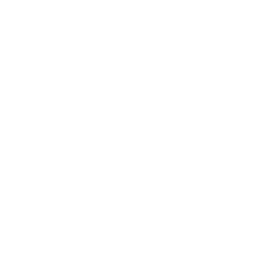

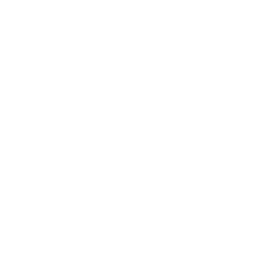

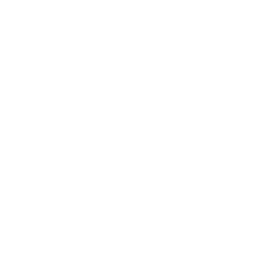

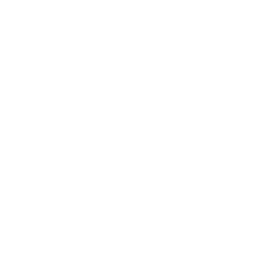

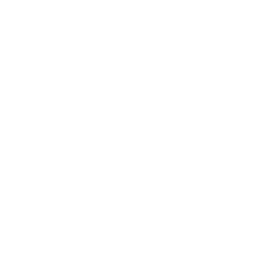

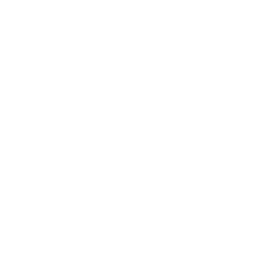

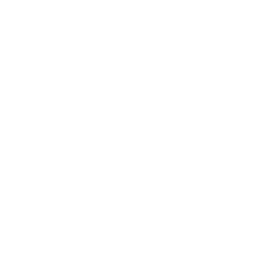

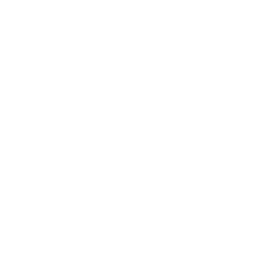

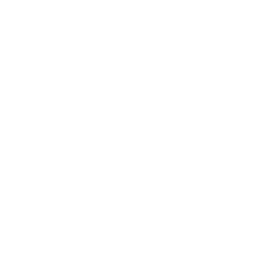

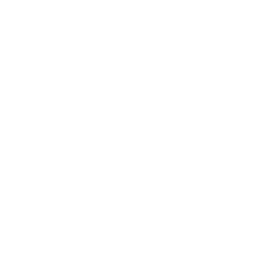

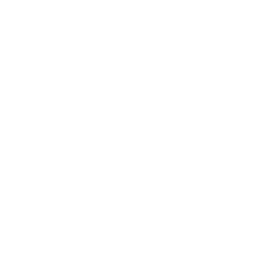

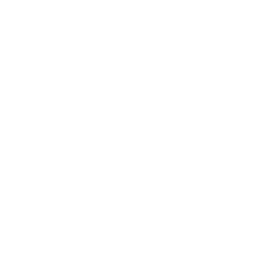

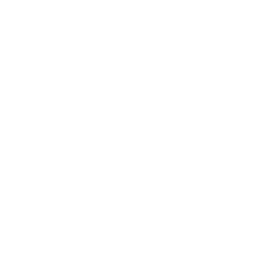

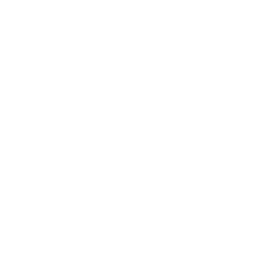

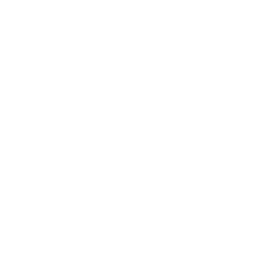

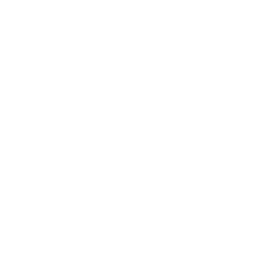

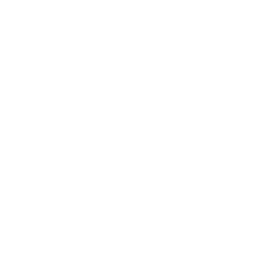

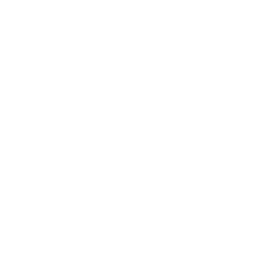

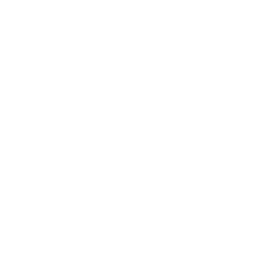

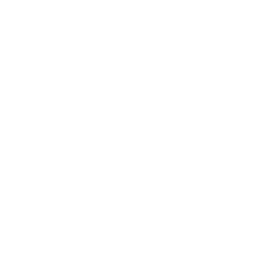

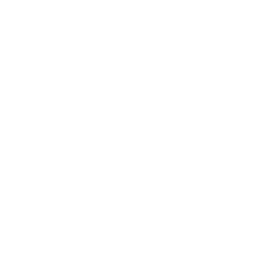

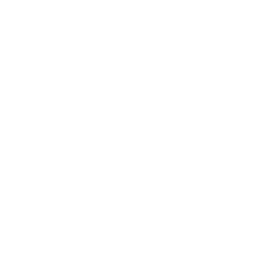

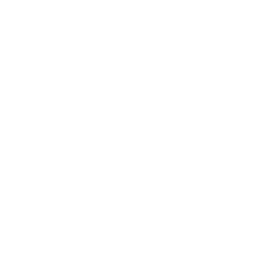

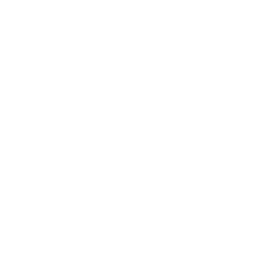

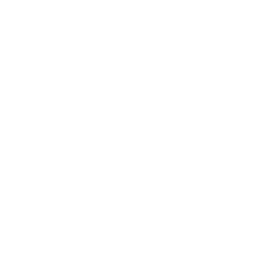

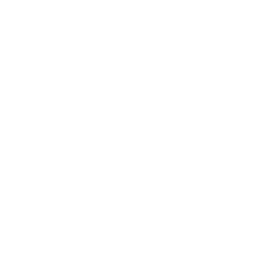

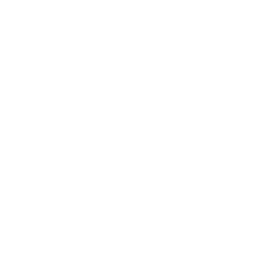

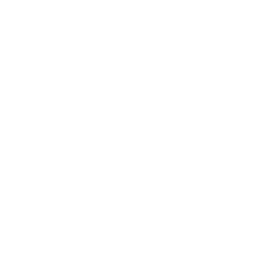

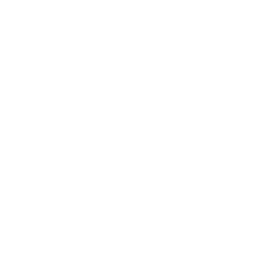

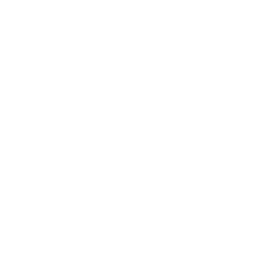

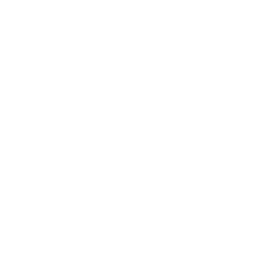

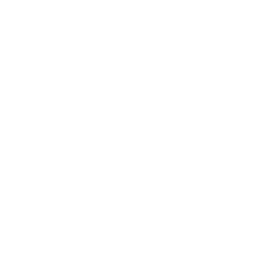

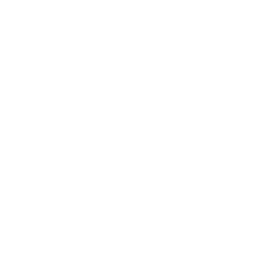

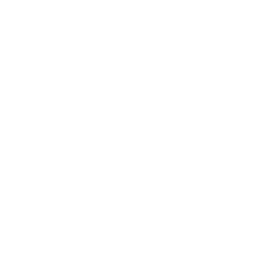

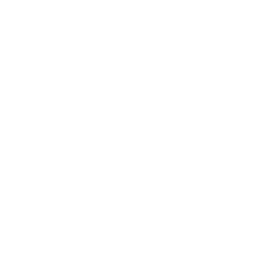

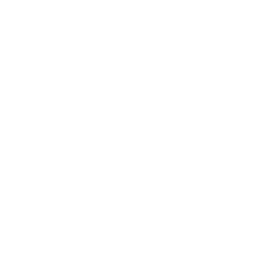

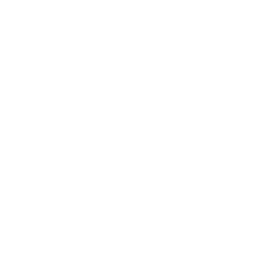

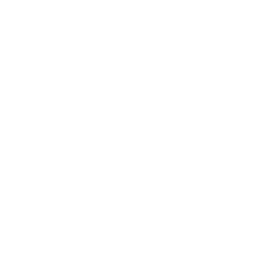

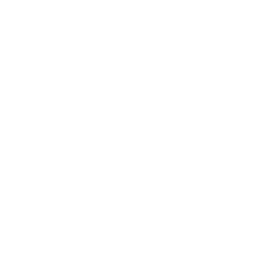

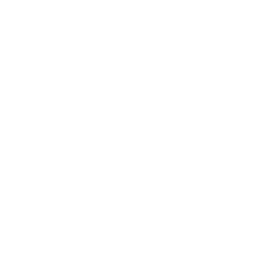

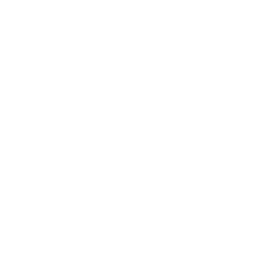

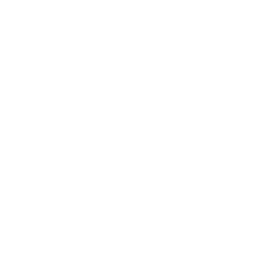

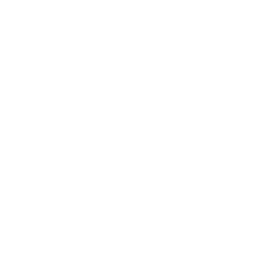

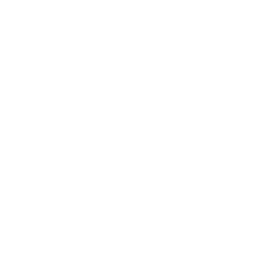

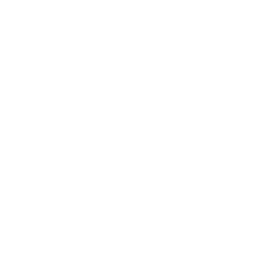

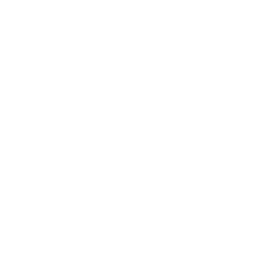

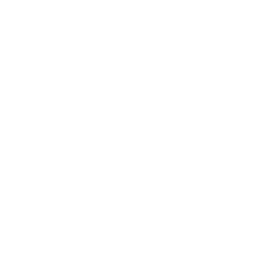

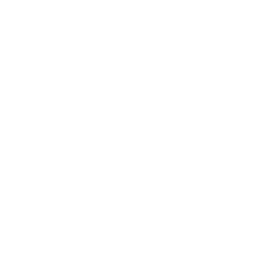

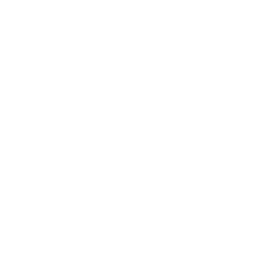

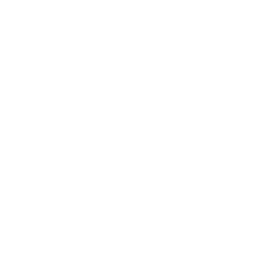

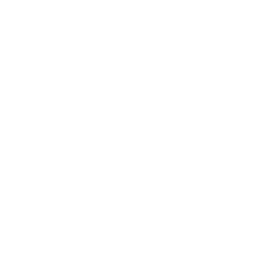

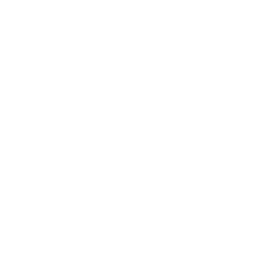

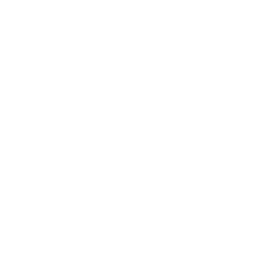

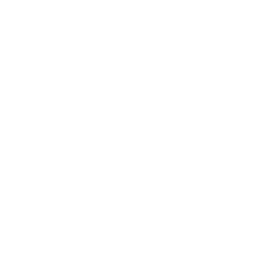

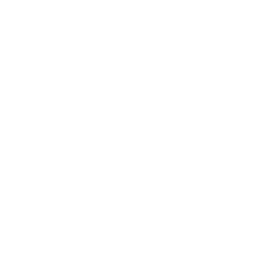

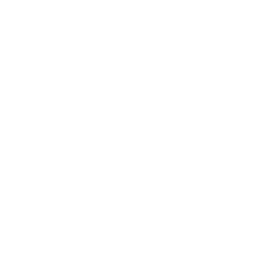

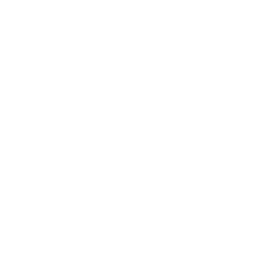

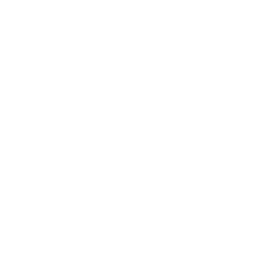

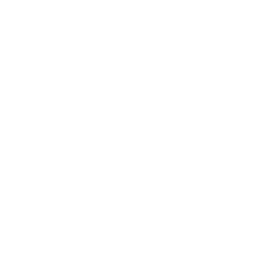

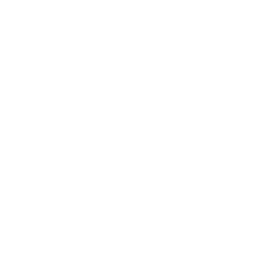

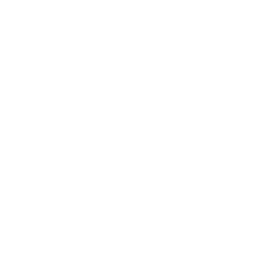

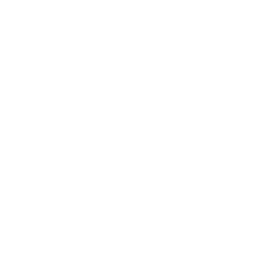

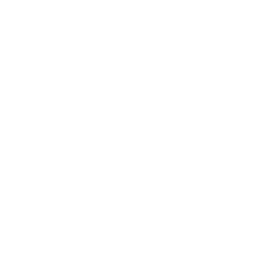

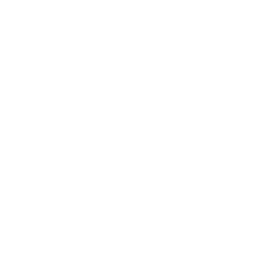

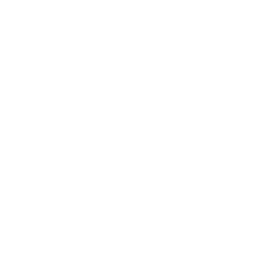

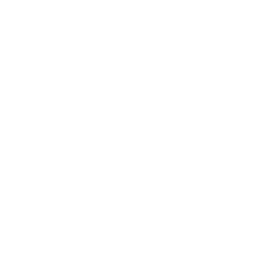

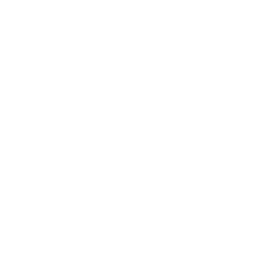

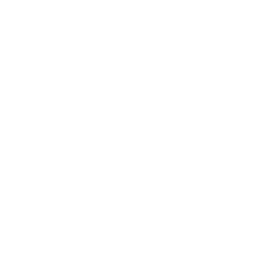

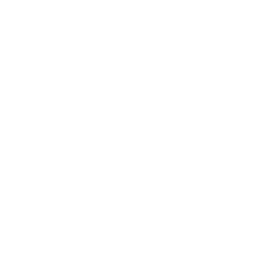

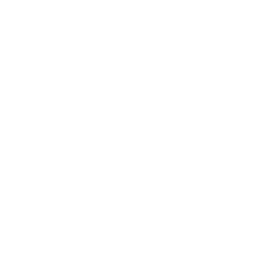

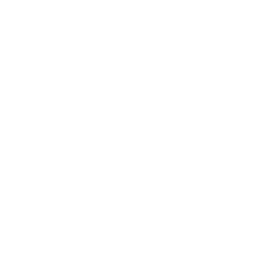

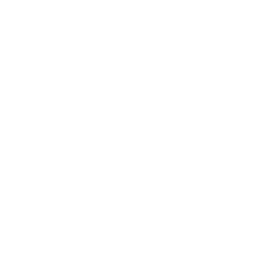

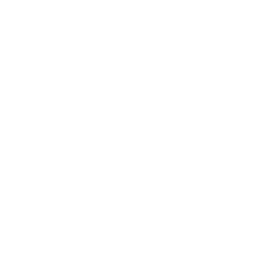

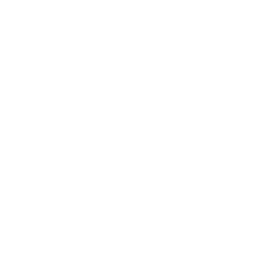

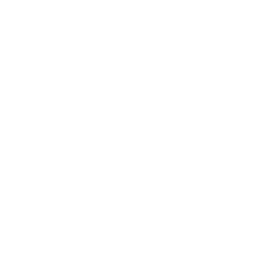

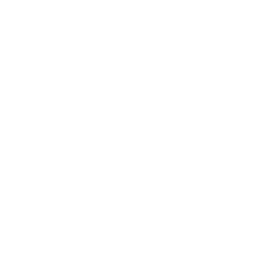

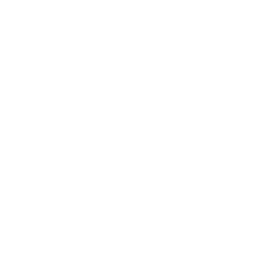

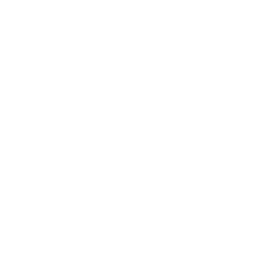

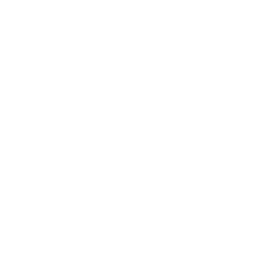

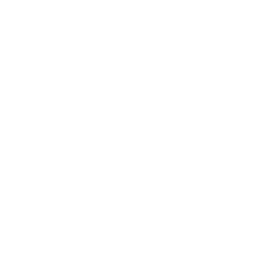

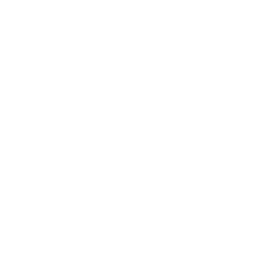

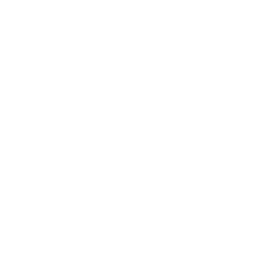

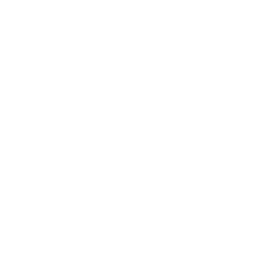

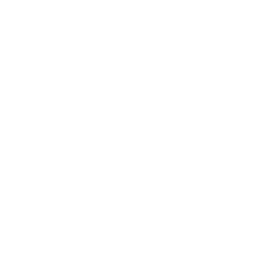

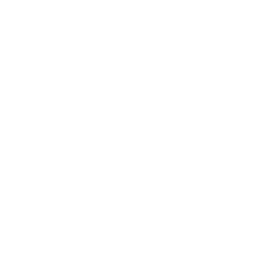

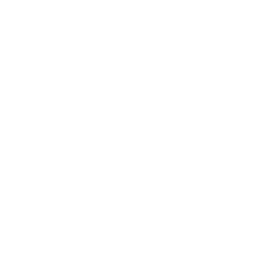

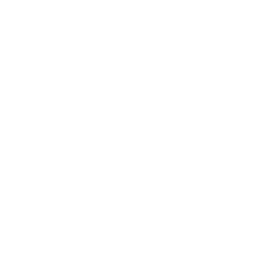

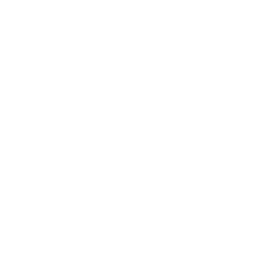

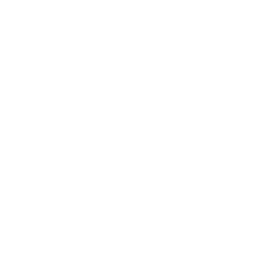

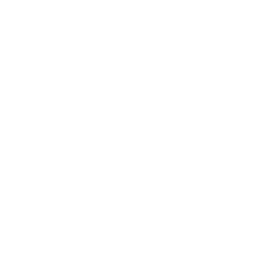

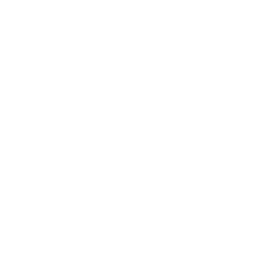

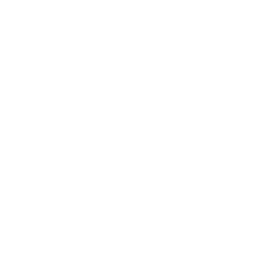

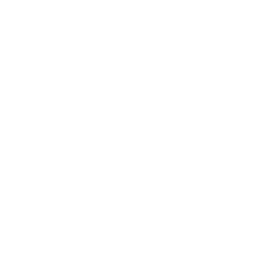

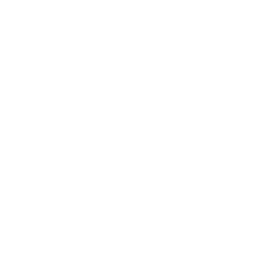

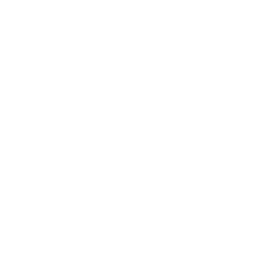

In [24]:
train_gan(generator,discriminator,gan_model,image_list,batch_size,noise_shape,50000)

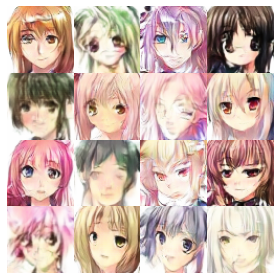

In [29]:
X,y = generate_fake_samples(generator,batch_size,noise_shape)
save_img_batch(X,101)

In [30]:
generator.save('gan_generator.h5')
discriminator.save('gan_discriminator.h5')
gan_model.save('gan_model.h5')

In [31]:
generator.save_weights('gan_generator_weights')
discriminator.save_weights('gan_discriminator_weights')
# gan_model.save('gan_model.h5')